In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2
from qiskit import *

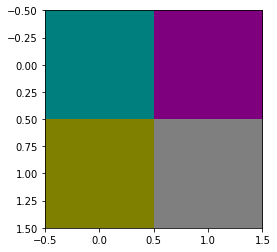

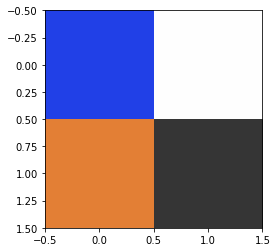

In [2]:
C_Image = np.zeros([2,2,3]) # (x,y,RGB)

C_Image[0,0,:] = (0,   128, 128)
C_Image[0,1,:] = (128, 0,   128)
C_Image[1,0,:] = (128, 128, 0)
C_Image[1,1,:] = (128, 128, 128)

plt.imshow(C_Image/256)
plt.show()

W_Image = np.zeros([2,2,3]) # (x,y,RGB)

W_Image[0,0,:] = (34,   65, 232)
W_Image[0,1,:] = (255, 255,   255)
W_Image[1,0,:] = (228, 128, 54)
W_Image[1,1,:] = (54, 54, 54)

plt.imshow(W_Image/256)
plt.show()

In [57]:
def get_Coeff(Image, watermark=None):
    """ Function that takes in an RGB image matrix of any size and shape and returns qubit coefficients"""
    
    ## build in check sizes Image and watermark are the same
    
    height = Image.shape[0]
    width = Image.shape[1]
    flat_rgb_values = np.reshape(Image, np.shape(Image)[0]*np.shape(Image)[1]*3)

    M = width*height*3 # Number of data points (height, width, 3 rgb values for each pixel)
    n = np.ceil(np.log2(M))
    N = int(round(2**n))

    flat_image_data = np.zeros(N)
    flat_image_data[0:flat_rgb_values.size] = flat_rgb_values

    Theta = flat_image_data*np.pi/255
    
    if watermark is None:
        Phi = np.zeros(len(Theta))
    else:  
        flat_watermark_values = np.reshape(watermark, np.shape(watermark)[0]*np.shape(watermark)[1]*3)
        flat_watermark_data = np.zeros(N)
        flat_watermark_data[0:flat_watermark_values.size] = flat_watermark_values
        Phi = flat_watermark_data*np.pi/255

    N = np.ceil(np.log2(Theta.size))/2
    return Theta,1/(2**N)*np.ndarray.flatten(np.transpose(np.stack((np.cos(Theta/2),np.exp(1j*Phi)*np.sin(Theta/2)))))

In [58]:
State_vector = get_Coeff(C_Image, W_Image)[1]
State_vector

array([ 0.25      +0.00000000e+00j,  0.        +0.00000000e+00j,
        0.17623139+0.00000000e+00j,  0.1234387 +1.27300377e-01j,
        0.17623139+0.00000000e+00j, -0.17024908+4.95756767e-02j,
        0.17623139+0.00000000e+00j, -0.17732033+2.17154771e-17j,
        0.25      +0.00000000e+00j, -0.        +0.00000000e+00j,
        0.17623139+0.00000000e+00j, -0.17732033+2.17154771e-17j,
        0.17623139+0.00000000e+00j, -0.16760031+5.79019513e-02j,
        0.17623139+0.00000000e+00j, -0.00109228+1.77316963e-01j,
        0.25      +0.00000000e+00j,  0.        +0.00000000e+00j,
        0.17623139+0.00000000e+00j,  0.13950587+1.09455976e-01j,
        0.17623139+0.00000000e+00j,  0.13950587+1.09455976e-01j,
        0.17623139+0.00000000e+00j,  0.13950587+1.09455976e-01j,
        0.25      +0.00000000e+00j,  0.        +0.00000000e+00j,
        0.25      +0.00000000e+00j,  0.        +0.00000000e+00j,
        0.25      +0.00000000e+00j,  0.        +0.00000000e+00j,
        0.25      +0.0000

In [59]:
def initialise_state(desired_initial_state):
    n = int(round(np.log2(desired_initial_state.size)))
    
    # if 2**n != desired_initial_state.size:
        # don't run
    
    qc_init = QuantumCircuit(n)

    qc_init.initialize(desired_initial_state, range(n))
    return qc_init

In [60]:
qc_init = initialise_state(State_vector)
#qc_init.draw('mpl')

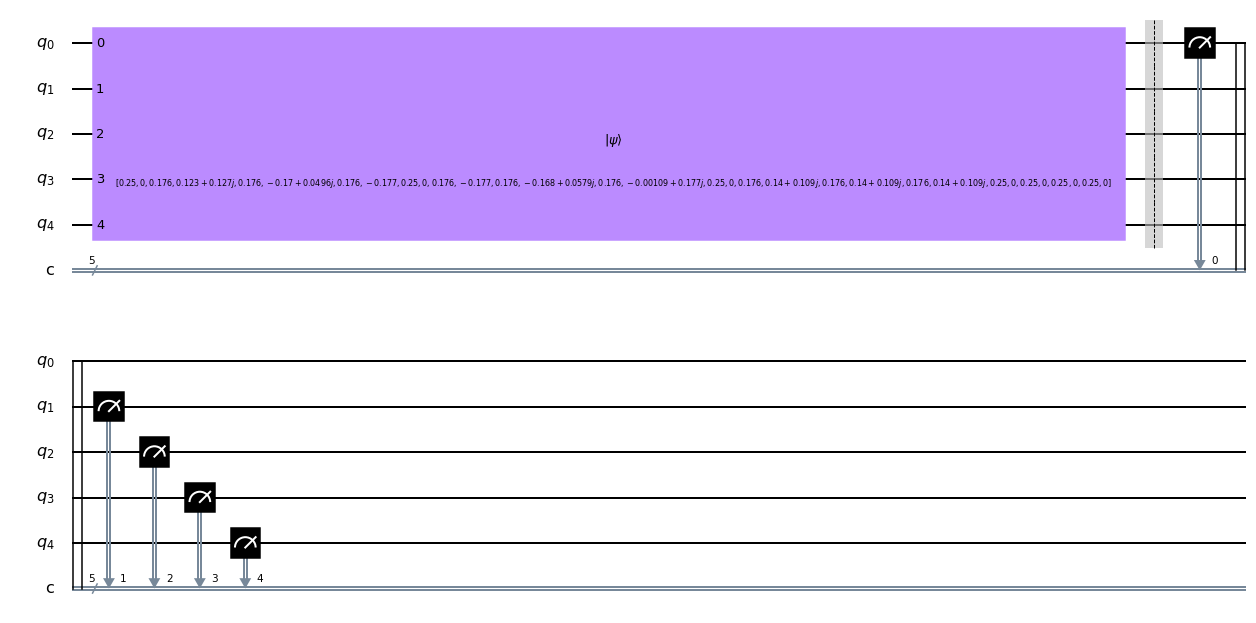

In [61]:
n = int(round(np.log2(State_vector.size)))
shots0 = 100000

# Create a Quantum Circuit
meas = QuantumCircuit(n, n)
meas.barrier(range(n))
# map the quantum measurement to the classical bits
meas.measure(range(n), range(n))

# The Qiskit circuit object supports composition using
# the addition operator.
qc = qc_init + meas

#drawing the circuit
qc.draw('mpl')

In [62]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
job_sim = execute(qc, backend_sim, shots=shots0)

# Grab the results from the job.
result_sim = job_sim.result()

{'00000': 6155, '10000': 6251, '10010': 3148, '10011': 3198, '10100': 3015, '10101': 3187, '10110': 3099, '10111': 3115, '11000': 6255, '11010': 6361, '11100': 6206, '11110': 6261, '00010': 3116, '00011': 3179, '00100': 3029, '00101': 3112, '00110': 3081, '00111': 3216, '01000': 6158, '01010': 3163, '01011': 3121, '01100': 3209, '01101': 3049, '01110': 3101, '01111': 3215}


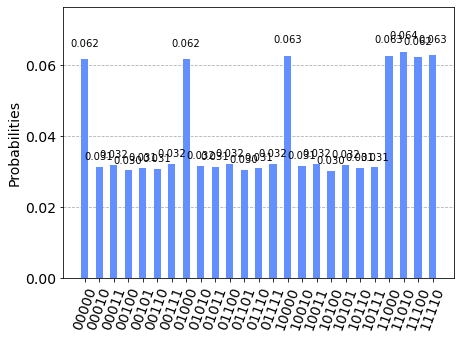

In [63]:
counts = result_sim.get_counts(qc)
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [64]:
probability_vector = np.zeros(2**n)
int_counts = counts.int_outcomes() # this changes the keys in the count object to integers so we can iterate through it easily

for k in range(2**n):
    probability_vector[k] = int_counts.get(k, 0)/shots0

print(probability_vector)

[0.06155 0.      0.03116 0.03179 0.03029 0.03112 0.03081 0.03216 0.06158
 0.      0.03163 0.03121 0.03209 0.03049 0.03101 0.03215 0.06251 0.
 0.03148 0.03198 0.03015 0.03187 0.03099 0.03115 0.06255 0.      0.06361
 0.      0.06206 0.      0.06261 0.     ]


In [65]:
p0 = probability_vector[0::2]
p1 = probability_vector[1::2]
print(p0)

[0.06155 0.03116 0.03029 0.03081 0.06158 0.03163 0.03209 0.03101 0.06251
 0.03148 0.03015 0.03099 0.06255 0.06361 0.06206 0.06261]


In [83]:
def get_RGB(P0, height, width):
    """ Function that takes the probablity distribution for the colour qubit 0 """
    
    arg = np.minimum(np.ones(len(P0)), np.sqrt((len(P0)*P0)))
    Theta = 2*np.arccos(arg)/np.pi*255
    Theta_new = Theta[0:height*width*3]

    return Theta_new, np.reshape(Theta_new,[height, width, 3])

[ 20.06543105 127.7337671  129.99390469 128.64289758  19.74446977
 126.51296038 125.31791389 128.12338421   0.         126.90259061
 130.35773989 128.17533405]


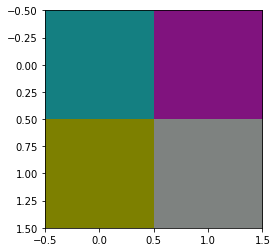

In [84]:
P_Image = get_RGB(p0, 2, 2)[1]
print(get_RGB(p0, 2, 2)[0])
plt.imshow(P_Image/255, vmin=0, vmax=1)
plt.show()